In [1]:
import warnings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
)

In [2]:
warnings.filterwarnings("ignore")

# ------------------- CONFIG -------------------
DATA_PATH = "uber.csv"
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Dataset not found at '{DATA_PATH}'. "
        "Make sure the CSV file is in the same directory."
    )

In [3]:
def haversine_np(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between two points."""
    lon1, lat1, lon2, lat2 = map(np.radians, (lon1, lat1, lon2, lat2))
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    )
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km


In [4]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def find_col(df, *names):
    for n in names:
        for c in df.columns:
            if c.lower() == n.lower():
                return c
    return None

In [5]:
df = pd.read_csv(DATA_PATH, low_memory=False)

pickup_dt_col = find_col(df, "pickup_datetime", "pickup_date", "datetime")
pu_lat_col = find_col(df, "pickup_latitude", "pickup_lat")
pu_lon_col = find_col(df, "pickup_longitude", "pickup_lon")
do_lat_col = find_col(df, "dropoff_latitude", "dropoff_lat")
do_lon_col = find_col(df, "dropoff_longitude", "dropoff_lon")
pass_col = find_col(df, "passenger_count", "passengers")
fare_col = find_col(df, "fare_amount", "fare")

required = [
    pickup_dt_col,
    pu_lat_col,
    pu_lon_col,
    do_lat_col,
    do_lon_col,
    pass_col,
    fare_col,
]

if any(x is None for x in required):
    raise ValueError("Required columns are missing in dataset.")

df = df.rename(
    columns={
        pickup_dt_col: "pickup_datetime",
        pu_lat_col: "pickup_latitude",
        pu_lon_col: "pickup_longitude",
        do_lat_col: "dropoff_latitude",
        do_lon_col: "dropoff_longitude",
        pass_col: "passenger_count",
        fare_col: "fare_amount",
    }
)


In [6]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")

df = df.dropna(
    subset=[
        "pickup_datetime",
        "pickup_latitude",
        "pickup_longitude",
        "dropoff_latitude",
        "dropoff_longitude",
        "fare_amount",
    ]
)

for c in [
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude",
    "fare_amount",
    "passenger_count",
]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna()

df = df[
    (df["fare_amount"] > 0)
    & (df["fare_amount"] < 5000)
    & (df["pickup_latitude"].between(-90, 90))
    & (df["dropoff_latitude"].between(-90, 90))
    & (df["pickup_longitude"].between(-180, 180))
    & (df["dropoff_longitude"].between(-180, 180))
]

In [7]:
df["passenger_count"] = df["passenger_count"].fillna(1).astype(int)
df.loc[~df["passenger_count"].between(1, 8), "passenger_count"] = 1

df["distance_km"] = haversine_np(
    df["pickup_longitude"],
    df["pickup_latitude"],
    df["dropoff_longitude"],
    df["dropoff_latitude"],
)

df["pickup_hour"] = df["pickup_datetime"].dt.hour
df["pickup_weekday"] = df["pickup_datetime"].dt.weekday
df["pickup_month"] = df["pickup_datetime"].dt.month
df["pickup_year"] = df["pickup_datetime"].dt.year

df = df[df["distance_km"] > 0.01]

Correlation matrix:
                  fare_amount  distance_km  passenger_count  pickup_hour  \
fare_amount         1.000000     0.818676         0.015974    -0.003211   
distance_km         0.818676     1.000000         0.005489    -0.026061   
passenger_count     0.015974     0.005489         1.000000     0.015976   
pickup_hour        -0.003211    -0.026061         0.015976     1.000000   
pickup_weekday      0.018118     0.040504         0.037331    -0.086851   
pickup_month        0.030170     0.005437         0.008666    -0.002973   

                 pickup_weekday  pickup_month  
fare_amount            0.018118      0.030170  
distance_km            0.040504      0.005437  
passenger_count        0.037331      0.008666  
pickup_hour           -0.086851     -0.002973  
pickup_weekday         1.000000     -0.009589  
pickup_month          -0.009589      1.000000  


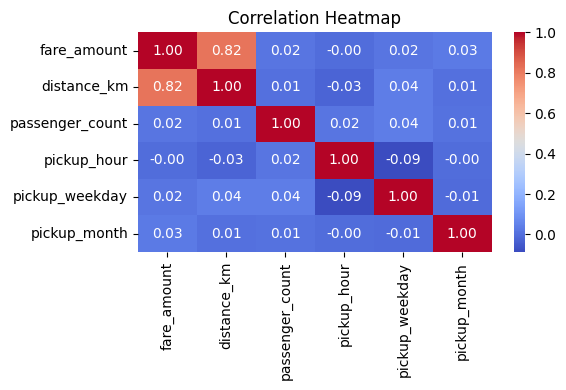


Linear Regression:
R2: 0.6750
RMSE: 2.2617
MAE: 1.6287

Random Forest:
R2: 0.6648
RMSE: 2.2969
MAE: 1.6599


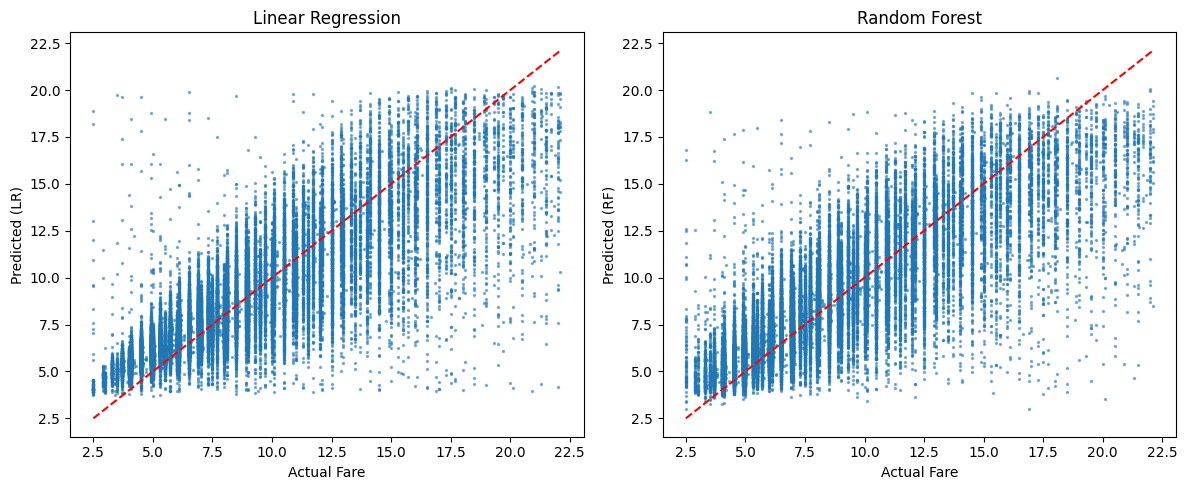


Random Forest Feature Importances:
 distance_km        0.837036
pickup_hour        0.055330
pickup_month       0.050409
pickup_weekday     0.034648
passenger_count    0.022578
dtype: float64

Sample predictions saved to 'uber_fare_predictions_sample.csv'


In [8]:
# ------------------- OUTLIER DETECTION -------------------

def iqr_bounds(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return q1 - k * iqr, q3 + k * iqr


fare_low, fare_high = iqr_bounds(df["fare_amount"])
dist_low, dist_high = iqr_bounds(df["distance_km"])

outlier_mask = (
    (df["fare_amount"] < fare_low)
    | (df["fare_amount"] > fare_high)
    | (df["distance_km"] < dist_low)
    | (df["distance_km"] > dist_high)
)

df_no_out = df[~outlier_mask].copy()

# ------------------- CORRELATION -------------------
corr_features = [
    "fare_amount",
    "distance_km",
    "passenger_count",
    "pickup_hour",
    "pickup_weekday",
    "pickup_month",
]

corr = df_no_out[corr_features].corr()
print("Correlation matrix:\n", corr)

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# ------------------- MODELING -------------------
X = df_no_out[
    [
        "distance_km",
        "passenger_count",
        "pickup_hour",
        "pickup_weekday",
        "pickup_month",
    ]
]
y = df_no_out["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = rmse(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print("\nLinear Regression:")
print(f"R2: {r2_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"MAE: {mae_lr:.4f}")

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = rmse(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("\nRandom Forest:")
print(f"R2: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")

print(f"MAE: {mae_rf:.4f}")

# ------------------- VISUALIZATION -------------------
results = pd.DataFrame(
    {"actual": y_test, "pred_lr": y_pred_lr, "pred_rf": y_pred_rf}
).reset_index(drop=True)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(results["actual"], results["pred_lr"], s=2, alpha=0.5)
plt.plot(
    [results["actual"].min(), results["actual"].max()],
    [results["actual"].min(), results["actual"].max()],
    "r--",
)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted (LR)")
plt.title("Linear Regression")

plt.subplot(1, 2, 2)
plt.scatter(results["actual"], results["pred_rf"], s=2, alpha=0.5)
plt.plot(
    [results["actual"].min(), results["actual"].max()],
    [results["actual"].min(), results["actual"].max()],
    "r--",
)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted (RF)")
plt.title("Random Forest")

plt.tight_layout()
plt.show()

# ------------------- FEATURE IMPORTANCES -------------------
importances = pd.Series(
    rf.feature_importances_, index=X.columns
).sort_values(ascending=False)
print("\nRandom Forest Feature Importances:\n", importances)

# Save sample predictions
results.sample(n=min(200, len(results)), random_state=42).to_csv(
    "uber_fare_predictions_sample.csv", index=False
)
print("\nSample predictions saved to 'uber_fare_predictions_sample.csv'")

In [9]:
# 🚖 UBER FARE PREDICTION PROJECT EXPLANATION 🚖
# -------------------------------------------------
# This project predicts Uber ride fares using Machine Learning.
# The dataset is first cleaned by removing missing, incorrect, or out-of-range values 
# such as negative fares or invalid latitude and longitude coordinates.
#
# The Haversine formula is applied to calculate the real-world distance (in km)
# between pickup and drop-off locations using their latitude and longitude values. 
# This helps in determining how distance affects fare prices.
#
# Next, time-related features like pickup hour, weekday, and month are extracted 
# from the pickup timestamp — this helps the model learn time-based fare variations 
# (for example, rush hour or weekend effects).
#
# Outliers in both fare and distance columns are detected using the Interquartile Range (IQR) method 
# and removed to make the model more accurate and stable.
#
# Two models are then trained:
# 1️⃣ Linear Regression — to understand simple, direct relationships between distance and fare.
# 2️⃣ Random Forest Regression — to capture complex, non-linear relationships between multiple features.
#
# Both models are evaluated using performance metrics:
# - R² Score (measures how well the model fits the data)
# - RMSE (Root Mean Square Error — measures average prediction error)
# - MAE (Mean Absolute Error — measures how far predictions are from actual fares)
#
# The Random Forest model usually performs better as it handles non-linear patterns effectively.
#
# Finally, results are visualized using scatter plots to compare actual vs predicted fares, 
# and feature importance is calculated to identify which factors (like distance, time, passenger count) 
# have the most influence on the fare prediction.
#
# A CSV file of sample predictions is also saved for quick verification and analysis.
